## Installed packages

In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri

from dataclasses import dataclass
from enum import Enum
from scipy import interpolate
from scipy.signal import correlate
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

coords.append([0,0])#node_2
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(0,0,0,0.001)
coords.append([lon,lat])#node_0
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(0,0,270,0.001)
coords.append([lon,lat])#node_1
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(0,0,90,1000)
coords.append([lon,lat])#node_3
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(lon,lat,90,25000)
coords.append([lon,lat])#node_4
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(lon,lat,90,1000)
coords.append([lon,lat])#node_5
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(lon,lat,90,1000)
coords.append([lon,lat])#node_6
lon,lat,_ = pyproj.Geod(ellps='WGS84').fwd(lon,lat,90,5*300)
coords.append([lon,lat])#node_7

node_names = ['Node 2','Node 0','Node 1','Node 3','Node 4','Node 5','Node 6','Node 7']
for d in range(len(coords)):
    data_node = {"env": [],
                 "name": node_names[d],
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)
    
path.append([nodes[0],nodes[1]]) 
path.append([nodes[1],nodes[0]])
path.append([nodes[0],nodes[2]]) 
path.append([nodes[2],nodes[0]])
path.append([nodes[0],nodes[3]]) 
path.append([nodes[3],nodes[0]])
path.append([nodes[3],nodes[4]]) 
path.append([nodes[4],nodes[3]])
path.append([nodes[4],nodes[5]]) 
path.append([nodes[5],nodes[4]])
path.append([nodes[5],nodes[6]]) 
path.append([nodes[6],nodes[5]])
path.append([nodes[6],nodes[7]]) 
path.append([nodes[7],nodes[6]])

FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {})

In [3]:
simulation_start = datetime.datetime(2022,1,1)
sim = model.Simulation(simulation_start,FG)
env = sim.environment
duration = 5*12.5*60*60 #seconds

In [4]:
env.FG = FG

origin = core.IsOrigin(env = env, name = 'Origin')
anchorage = core.IsAnchorage(env = env, name = 'Anchorage', node = 'Node 0', type = 'sea_going_vessels',max_capacity = 50)
turning_basin = core.IsTurningBasin(env = env, name = 'Turning Basin', node = 'Node 5', length = 300)
terminal = core.IsTerminal(env = env, name = 'Liquid bulk terminal',length = 700, jetty_locations = [100,200,300,400,500], jetty_lengths = [300,300,300,300,300], node_start = 'Node 6', node_end = 'Node 7', type = 'jetty')

In [5]:
FG.nodes["Node 0"]["Anchorage"] = [anchorage]
FG.nodes["Node 1"]["Origin"] = [origin]
FG.nodes["Node 5"]["Turning Basin"] = [turning_basin]
FG.edges['Node 6','Node 7']["Terminal"] = [terminal]

FG.nodes["Node 0"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #anchorage 2
FG.nodes["Node 0"]["Junction"].name = ['anchorage_access']
FG.nodes["Node 0"]["Junction"].type = ['two-way_traffic']

FG.nodes["Node 1"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #origin
FG.nodes["Node 1"]["Junction"].name = ['waterway_access']
FG.nodes["Node 1"]["Junction"].type = ['two-way_traffic']

FG.nodes["Node 2"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #neural point
FG.nodes["Node 2"]["Junction"].name = ['anchorage_access','waterway_access','waterway_access']
FG.nodes["Node 2"]["Junction"].type = ['two-way_traffic','two-way_traffic','two-way_traffic']

FG.nodes["Node 4"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #turn Basin acccess to 3e PH
FG.nodes["Node 4"]["Junction"].name = ['waterway_access','harbour_basin_access']
FG.nodes["Node 4"]["Junction"].type = ['two-way_traffic','one-way_traffic']

FG.nodes["Node 7"]["Junction"] = core.IsJunction(env = [], name = [], sections = [], type = []) #end point route
FG.nodes["Node 7"]["Junction"].name = ['harbour_basin_access']
FG.nodes["Node 7"]["Junction"].type = ['one-way_traffic']


junction_nodes = []
for node in list(FG.nodes):
    if 'Junction' in FG.nodes[node]:
        junction_nodes.append(node)
        
for node1 in junction_nodes:
    names = []
    sections = []
    types = []
    for node2 in junction_nodes:
        if node1 == node2:
            continue
            
        route = nx.dijkstra_path(FG, node1, node2)
        section = True
        for node in route[1:-1]:
            if 'Junction' in FG.nodes[node]:
                section = False
                break

        if section:
            sections.append([node1,node2])
            names.append(FG.nodes[node1]["Junction"].name[len(sections)-1])
            types.append(FG.nodes[node1]["Junction"].type[len(sections)-1])
    
    FG.nodes[node1]["Junction"] = [core.IsJunction(env = env, name = names, sections = sections, type = types)]

for edge in enumerate(FG.edges):
    if 'Terminal' in FG.edges[edge[1]]:
        FG.edges[edge[1][1],edge[1][0]]['Terminal'] = FG.edges[edge[1]]['Terminal']

In [6]:
# List 8 vessels
vdf = pd.DataFrame()
vdf[0] = ['Small coaster 1','Small coaster 2','Coaster','Handysize','Tanker MR','Tanker LR1','Tanker LR2 1','Tanker LR2 2']
vdf[1] = [71,110,126,149,184,228,243,249] #length
vdf[2] = [10.1,13.5,19,22,27,32,42,46] #beam
vdf[3] = [4.5,5.45,8.5,10,11.4,12.1,13.6,15] # draught + FWA
vdf[4] = 0.5*vdf[3] #unloaded draught
vdf[5] = [17,17,17,17,17,17,17,17] #H_e free board empty- Update!
vdf[6] = vdf[5]-(vdf[3]-vdf[4]) #H_f free board loaded
vdf[7] = [60,60,60,60,60,60,60,60] #t_b in minutes - berthing time (assumed in 1hs)
vdf[8] = [15*60,16.7*60,16.7*60,18.3*60,18.3*60,18.3*60,18.3*60,18.3*60] #t_l loading + unloading time (in minutes)
vdf[9] = [0,0,0,0,0,0,0,0] #UKC
vdf[10] = [4.5,4.5,4.5,4.5,4.5,4.5,4.5,4.5] # vessel speed in m/s - check with S. de Jong thesis
# vdf[10] = [6,6,6,6,6,6,6,6] # vessel speed in m/s - own assumption
vdf[11] = [18*60*60,18*60*60,18*60*60,18*60*60,18*60*60,18*60*60,18*60*60,18*60*60] # max waiting time in seconds
vdf[12] = [0,0,0,0,0,0,0,0] #critical cross-current velocity in m/s
vdf.columns = ['type','L','B','T_f','T_e','H_e','H_f','t_b','t_l','ukc','v','max_waiting_time','max_cross_current']

In [7]:
## USE THIS CELL FOR SHIP GENERATOR WITH constant ARRIVAL RATE
Vessel = type('Vessel', 
              (core.Identifiable, core.HasOrigin, core.HasTerminal, core.HasSection, core.HasAnchorage, core.HasTurningBasin, core.Movable, core.Routeable, core.VesselProperties, core.ExtraMetadata), {})

generator_sea = model.VesselGenerator(Vessel,vdf,random_seed=3)

In [8]:
### USE THIS CELL FOR SHIP GENERATOR WITH constant ARRIVAL RATE
origin = 'Node 1' #coasters should enter empty and leave full (export) --> UPDATE SOMEWHERE
destination = 'Node 7'
vessel_name = 'MR'
vessel_type = 'Tanker'
vessel_index = vdf['type'].tolist().index(vessel_type+' '+vessel_name)
vessel = Vessel(name=vessel_name,
                 geometry=FG.nodes[origin]['geometry'],
                 route=nx.dijkstra_path(FG,origin,destination),
                 env=env,
                 type=vessel_type,
                 B = vdf['B'][vessel_index],
                 L = vdf['L'][vessel_index],
                 T_f = vdf['T_f'][vessel_index],
                 T_e = vdf['T_e'][vessel_index],
                 H_e = vdf['H_e'][vessel_index],
                 H_f = vdf['H_f'][vessel_index],
                 t_b = vdf['t_b'][vessel_index],
                 t_l = vdf['t_l'][vessel_index],
                 ukc = vdf['ukc'][vessel_index],
                 v = vdf['v'][vessel_index],
                 max_waiting_time = vdf['max_waiting_time'][vessel_index],
                 max_cross_current = vdf['max_cross_current'][vessel_index],
                 start_time = 0,)
sim.add_vessels(origin,destination,[],vessel)

In [29]:
def current_direction_calculator(delay):
    current_directions = []
    tidal_period = 'Flood'
    tidal_period_count = 0
    for t in range(len(time)):
        if t == 0:
            if tidal_period == 'Flood':
                current_direction = 90/360*2*np.pi
            elif tidal_period == 'Ebb':
                current_direction = 270/360*2*np.pi
            current_directions.append(current_direction)
            continue

        if tidal_period_count == 0 and (time[t])%(0.25*12.5*60*60+delay) < (time[t-1])%(0.25*12.5*60*60+delay):
            if tidal_period == 'Flood':
                tidal_period = 'Ebb'
            elif tidal_period == 'Ebb':
                tidal_period = 'Flood'
            tidal_period_count += 1

        elif tidal_period_count >= 1 and (time[t]-0.25*12.5*60*60-delay)%(0.5*12.5*60*60) < (time[t-1]-0.25*12.5*60*60-delay)%(0.5*12.5*60*60):
            if tidal_period == 'Flood':
                tidal_period = 'Ebb'
            elif tidal_period == 'Ebb':
                tidal_period = 'Flood'
            tidal_period_count += 1

        if tidal_period == 'Flood':
            current_direction = 90/360*2*np.pi
        elif tidal_period == 'Ebb':
            current_direction = 270/360*2*np.pi    
        current_directions.append(current_direction)
    return current_directions

In [34]:
time = np.arange(0,duration,600)
MBLs = [50,50,50,15,15,50,50,50]
widths = [1000,1000,1000,1000,1000,1000,1000,1000]
delay = (1/4)*12.5*60*60

water_level_node_0 = water_level_node_1 = water_level_node_2 = np.sin(time/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi)
water_level_node_3 = np.sin(time/(12.5*60*60)*2*np.pi-(1000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi)
water_level_node_4 = np.sin(time/(12.5*60*60)*2*np.pi-(26000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi)
water_level_node_5 = np.sin(time/(12.5*60*60)*2*np.pi-(27000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi)
water_level_node_6 = np.sin(time/(12.5*60*60)*2*np.pi-(28000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi)
water_level_node_7 = np.sin(time/(12.5*60*60)*2*np.pi-(29500/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi)
water_levels = [water_level_node_0,water_level_node_1,water_level_node_2,water_level_node_3,water_level_node_4,water_level_node_5,water_level_node_6,water_level_node_7]

current_velocity_node_0 = current_velocity_node_1 = current_velocity_node_2 = abs(np.cos(time/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi))
current_velocity_node_3 = abs(np.cos(time/(12.5*60*60)*2*np.pi-(1000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi))
current_velocity_node_4 = abs(np.cos(time/(12.5*60*60)*2*np.pi-(26000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi))
current_velocity_node_5 = abs(np.cos(time/(12.5*60*60)*2*np.pi-(27000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi))
current_velocity_node_6 = abs(np.cos(time/(12.5*60*60)*2*np.pi-(28000/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi))
current_velocity_node_7 = abs(np.cos(time/(12.5*60*60)*2*np.pi-(29500/10)/(12.5*60*60)*2*np.pi+delay/(12.5*60*60)*2*np.pi))
current_velocities = [current_velocity_node_0,current_velocity_node_1,current_velocity_node_2,current_velocity_node_3,current_velocity_node_4,current_velocity_node_5,current_velocity_node_6,current_velocity_node_7]

current_direction_node_0 = current_direction_node_1 = current_direction_node_2 = current_direction_calculator(0-delay)
current_direction_node_3 = current_direction_calculator(1000/10)
current_direction_node_4 = current_direction_calculator(26000/10)
current_direction_node_5 = current_direction_calculator(27000/10)
current_direction_node_6 = current_direction_calculator(28000/10)
current_direction_node_7 = current_direction_calculator(29500/10)
current_directions = [current_direction_node_0,current_direction_node_1,current_direction_node_2,current_direction_node_3,current_direction_node_4,current_direction_node_5,current_direction_node_6,current_direction_node_7]

<ipython-input-29-48b8b65a96d3>:14: RuntimeWarning:

invalid value encountered in double_scalars



In [11]:
#define variables
depth = [[],[]]
width = [[],[]]
MBL = [[],[]]
water_level= [[],[]]
current_velocity = [[],[]]
current_direction = [[],[]]

# depth according to MBL values, and waterway navigational width obtained from measuring on HavenKaart
MBL[1] = MBLs
depth[1] = MBL[1]
width[1] = widths

# load water level, velocity magnitude and direction time series to each node
for nodes in enumerate(FG.nodes):
    MBL[0].append(FG.nodes[nodes[1]]['geometry'])
    width[0].append(FG.nodes[nodes[1]]['geometry'])
    depth[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[0].append((FG.nodes[nodes[1]]['geometry']))
    water_level[1].append([[],[]])
    current_velocity[0].append((FG.nodes[nodes[1]]['geometry']))
    current_velocity[1].append([[],[]])
    current_direction[0].append((FG.nodes[nodes[1]]['geometry']))
    current_direction[1].append([[],[]])
    
for col in enumerate(water_levels): #load water level
    water_level[1][col[0]][0]=[x+simulation_start.timestamp() for x in time]
    water_level[1][col[0]][1]=list(col[1])
    
for col in enumerate(current_velocities): #load velocity magnitude
    current_velocity[1][col[0]][0]=[x+simulation_start.timestamp() for x in time]
    current_velocity[1][col[0]][1]=list(col[1])
     
for col in enumerate(current_directions): #load velocity direction
    current_direction[1][col[0]][0]=[x+simulation_start.timestamp() for x in time]
    current_direction[1][col[0]][1]=list(col[1])

core.NetworkProperties.append_data_to_nodes(FG,width,depth,MBL,water_level,current_velocity,current_direction)
knots = 0.51444444444444

In [12]:
class window_method(Enum):
    critical_cross_current = 'Critical cross-current'
    point_based = 'Point-based'
    
class vessel_characteristics(Enum):
    min_ge_Length = ['minLength','>=']
    min_gt_Length = ['minLength','>']
    max_le_Length = ['maxLength','<=']
    max_lt_Length = ['maxLength','<']
    min_ge_Draught = ['minDraught','>=']
    min_gt_Draught = ['minDraught','>']
    max_le_Draught = ['maxDraught','<=']
    max_lt_Draught = ['maxDraught','<']
    min_ge_Beam = ['minBeam','>=']
    min_gt_Beam = ['minBeam','>']
    max_le_Beam = ['maxBeam','<=']
    max_lt_Beam = ['maxBeam','<']
    min_ge_UKC = ['minUKC','>=']
    min_gt_UKC = ['minUKC','>']
    max_le_UKC = ['maxUKC','<=']
    max_lt_UKC = ['maxUKC','<']
    Type = ['Type','==']

class vessel_direction(Enum):
    inbound = 'inbound'
    outbound = 'outbound'
    
class vessel_type(Enum):
    GeneralCargo = 'GeneralCargo'
    LiquidBulk = 'LiquidBulk'
    Container = 'Container'
    DryBulk = 'DryBulk'
    MultiPurpose = 'MultiPurpose'
    Reefer = 'Reefer'
    RoRo = 'RoRo'
    Barge = 'Barge'
    
class accessibility(Enum):
    non_accessible = 0
    accessible = -1
    slack_water = 'min'
    
class tidal_period(Enum):
    Flood = 'Flood'
    Ebb = 'Ebb'
    
class current_velocity_type(Enum):
    CurrentVelocity = 'Current velocity'
    LongitudinalCurrent = 'Longitudinal current'
    CrossCurrent = 'Cross-current'
    
@dataclass
class vessel_specifications:
    vessel_characteristics: dict #{item of vessel_characteristics class: user-defined value,...}
    vessel_method: str #string containing the operators between the vessel characteristics (symbolized by x): e.g. '(x and x) or x'
    vessel_direction: str #item of vessel_direction class

    def characteristic_dicts(self):
        characteristic_dicts = {}
        for characteristic in self.vessel_characteristics:
            characteristic_dict = {characteristic.value[0]: [characteristic.value[1],self.vessel_characteristics[characteristic]]}
            characteristic_dicts = characteristic_dicts | characteristic_dict
        return characteristic_dicts

@dataclass
class window_specifications:
    window_method: str #item of window_method class
    current_velocity_values: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}
    current_velocity_ranges: dict = dict #if window_method is point-based: {tidal_period.Ebb.value: user-defined value,...}

@dataclass
class vtw_window_specifications:
    ukc_s: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}
    ukc_p: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}
    fwa: dict #{tidal_period.Flood.value: user-defined value or item from accessibility class,...}

@dataclass
class vertical_tidal_window_input:
    vessel_specifications: vessel_specifications #class
    window_specifications: window_specifications #class     
        
@dataclass
class horizontal_tidal_window_input:
    vessel_specifications: vessel_specifications #class
    window_specifications: window_specifications #class     
    condition: dict #{'Origin':node, 'Destination': node}
    data: list #Calculated input: [node,]

In [13]:
for node in FG.nodes:
    vertical_tidal_window_inputs = []

    vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 0},
                                                  'x',vessel_direction.inbound.value)

    window_specification = vtw_window_specifications({'ukc_s': 0.0},
                                                     {'ukc_p': 0.075},
                                                     {'fwa': 0.025})
    
    vertical_tidal_window_inputs.append(vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification))

    vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 0},
                                                  'x',vessel_direction.outbound.value)

    window_specification = vtw_window_specifications({'ukc_s': 0.0},
                                                     {'ukc_p': 0.075},
                                                     {'fwa': 0.025})

    vertical_tidal_window_inputs.append(vertical_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification))

    core.NetworkProperties.append_vertical_tidal_restriction_to_network(FG,node,vertical_tidal_window_inputs)

In [14]:
horizontal_tidal_window_inputs = []

#Inbound_Vessels_Condition1
vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 0},
                                              'x',vessel_direction.inbound.value)

window_specification = window_specifications(window_method.point_based.value,
                                             {tidal_period.Flood.value: accessibility.slack_water.value,tidal_period.Ebb.value: accessibility.slack_water.value},
                                             {tidal_period.Flood.value: 0.25,tidal_period.Ebb.value:0.25})

horizontal_tidal_window_inputs.append(horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification,
                                                                    condition = {'Origin': 'Node 3', 'Destination': 'Node 5'},
                                                                    data = ['Node 4', current_velocity_type.CurrentVelocity.value]))

#Outbound_Vessels_Condition1
vessel_specification = vessel_specifications({vessel_characteristics.min_ge_Draught: 0},
                                              'x',vessel_direction.outbound.value)

window_specification = window_specifications(window_method.point_based.value,
                                             {tidal_period.Flood.value: accessibility.slack_water.value,tidal_period.Ebb.value: accessibility.slack_water.value},
                                             {tidal_period.Flood.value: 0.25,tidal_period.Ebb.value:0.25})

horizontal_tidal_window_inputs.append(horizontal_tidal_window_input(vessel_specifications = vessel_specification,
                                                                    window_specifications = window_specification,
                                                                    condition = {'Origin': 'Node 5', 'Destination': 'Node 3'},
                                                                    data = ['Node 4', current_velocity_type.CurrentVelocity.value]))

core.NetworkProperties.append_horizontal_tidal_restriction_to_network(FG,'Node 4',horizontal_tidal_window_inputs)

In [15]:
sim.run(duration = duration) # this statement runs the simulation

In [16]:
def readjust_available_quay_lengths(aql,position):
    for i in range(len(aql)):
        if i == 0:
            continue
        if aql[i - 1][1] < position and aql[i][1] > position:
            break

    if i == 1:
        aql[i - 1][0] = 0
        aql[i][0] = 0

    elif i == len(aql) - 1:
        aql[i - 1][0] = 0
        aql[i][0] = 0

    else:
        aql[i - 1][0] = 0
        aql[i][0] = 0

    to_remove = []
    for i in enumerate(aql):
        for j in enumerate(aql):
            if i[0] != j[0] and i[1][0] == 0 and j[1][0] == 0 and i[1][1] == j[1][1]:
                to_remove.append(i[0])

    for i in list(reversed(to_remove)):
        aql.pop(i)

    return aql

def pick_minimum_length(aql,L):
    available_quay_lengths = [0]
    index_quay_position = 0
    move_to_anchorage = False
    for index in range(len(aql)):
        if index == 0 or aql[index][1] == aql[index - 1][1] or aql[index][0] == 1:
            if index == len(aql) - 1 and not index_quay_position:
                move_to_anchorage = True
            continue

        available_quay_lengths.append(aql[index][1] - aql[index - 1][1])

        for jndex in range(len(available_quay_lengths)):
            if L <= available_quay_lengths[jndex]:
                index_quay_position = index
                print(index_quay_position)
                break

            elif jndex == len(available_quay_lengths) - 1 and not index_quay_position:
                move_to_anchorage = True
        
        if index_quay_position != 0:
            break

    return index_quay_position, move_to_anchorage

def adjust_available_quay_lengths(aql, L, index_quay_position):
    if aql[index_quay_position - 1][0] == 0:
        aql[index_quay_position - 1][0] = 1

    if aql[index_quay_position][0] == 0 and aql[index_quay_position][1] == aql[index_quay_position - 1][1] + L:
        aql[index_quay_position][0] = 1
    else:
        aql.insert(index_quay_position, [1, L + aql[index_quay_position - 1][1]])
        aql.insert(index_quay_position + 1, [0, L + aql[index_quay_position - 1][1]])
        
    return aql

In [17]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the environment itself

In [18]:
# pd.set_option('display.max_rows', 500)
vessel = vessels[0]
df = pd.DataFrame.from_dict(vessel.log) #creates a data frame with all the info of vessels[0].

In [19]:
interp = sc.interpolate.CubicSpline(FG.nodes['Node 4']['Info']['Current velocity'][0],
                                    [y-1.0 for y in FG.nodes['Node 4']['Info']['Current velocity'][1]])
roots = interp.roots()
crossings = []
for root in roots:
    if root >= FG.nodes['Node 4']['Info']['Current velocity'][0][0] and root <= FG.nodes['Node 4']['Info']['Current velocity'][0][-1]:
        crossings.append(root-simulation_start.timestamp())
if len(crossings) < 2: estimated_waiting_time = 0
elif crossings[0] <= 26000/4.5: estimated_waiting_time = 0
else: estimated_waiting_time = crossings[0]-26000/4.5
    
if df['Message'][2] != 'Waiting in anchorage start': calculated_waiting_time = 0  
else: calculated_waiting_time = (df['Timestamp'][5]-df['Timestamp'][0]).total_seconds()

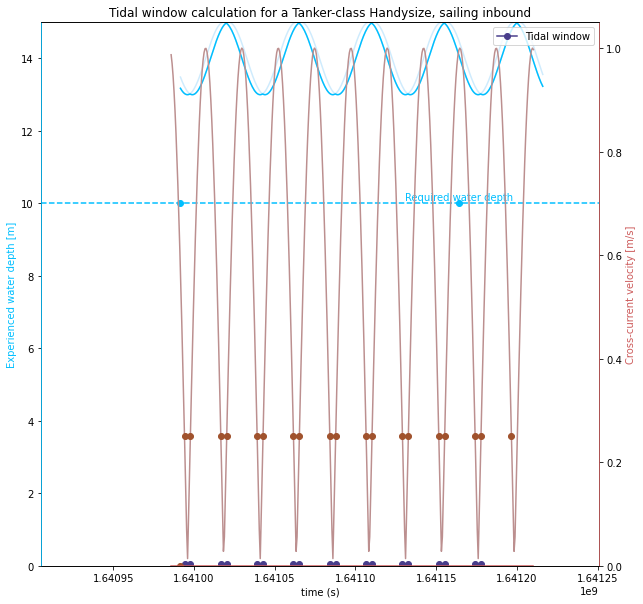

In [20]:
class Environment:
    def __init__(self,start_time,network):
        self.now = start_time
        self.FG = network

class Vessel:
    def __init__(self,start_time,T,ukc,typ,v,L,B,mccur,mwt,bound,network,start_node,end_node):
        self.name = 'Tanker'
        self.env = Environment(start_time,network)
        self.T_f = T
        self.L = L
        self.v = v
        self.B = B
        self.ukc = ukc
        self.metadata = {}
        self.metadata['ukc'] = ukc
        self.metadata['max_cross_current'] = mccur
        self.metadata['max_waiting_time'] = mwt
        self.bound = bound
        self.type = typ
        self.route = nx.dijkstra_path(self.env.FG, start_node, end_node)

vessel = Vessel(start_time = simulation_start.timestamp(),
                    T = 10,
                    L = 180,
                    v = 4.5,
                    B = 27,
                    ukc = 0,
                    mccur = 0,
                    mwt = 48*60*60,
                    bound = 'outbound',
                    typ = 'Handysize',
                    network = FG,
                    start_node = 'Node 1',
                    end_node = 'Node 7')

times_tidal_window_simulated = core.VesselTrafficService.provide_sail_in_times_tidal_window(vessel,
                                                                 route =vessel.route,
                                                                 plot=True)

#times = [t[0] for t in times_horizontal_tidal_window if t[0] >= simulation_start.timestamp() and t[0] <= simulation_start.timestamp()+vessel.metadata['max_waiting_time']]

In [21]:
def root_calculation(critcur):   
    def intp(critcur):
        intp = sc.interpolate.CubicSpline(FG.nodes['Node 4']['Info']['Horizontal tidal restriction']['Data']['Node 3'][0],
                                          [y-critcur for y in FG.nodes['Node 4']['Info']['Horizontal tidal restriction']['Data']['Node 3'][1]])
        return intp.roots()

    roots = [root for root in intp(critcur) if root >= simulation_start.timestamp() and root <= simulation_start.timestamp()+vessel.metadata['max_waiting_time']]

    return roots

In [22]:
def tidal_window_calculator(flood,ebb,typ):    
    roots_up = root_calculation(0.5*1.25)
    roots_normal = root_calculation(0.5)
    roots_down = root_calculation(0.5*0.75)
    roots_min = root_calculation(0.25)
    roots_tide = [t[0] for t in FG.nodes['Node 4']['Info']['Tidal periods'] if t[0] < simulation_start.timestamp()+vessel.metadata['max_waiting_time']]
    root_sim = simulation_start.timestamp()
    times_tidal_window_calculated = []
    if flood == 'range':
        if ebb == 'range':
            if typ == 'If':
                for root in enumerate(roots_up):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_up):
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        times_tidal_window_calculated.append([root_sim, 'Stop'])
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            if typ == 'Ie':
                for root in enumerate(roots_up):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_up):
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        times_tidal_window_calculated.append([root_sim, 'Stop'])
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
        elif ebb == 'accessible':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0] == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0] == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0])%4 == 0 or root[0] == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                for root in enumerate(roots_tide):
                    if root[0] == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_up):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_up):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_up):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
        elif ebb == 'non-accessible':
            if typ == 'If':
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                for root in enumerate(roots_up):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                for root in enumerate(roots_up):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                for root in enumerate(roots_up):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_up):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
        elif ebb == 'slack':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if (root[0]%4 == 0 or (root[0]-1)%4 == 0) and root[0] != 1:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if root[0] == 0:
                        continue
                    if (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                for root in enumerate(roots_min):
                    if root[0]%4 == 0 or (root[0]-1)%4 == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if (root[0])%4 == 0 or (root[0]-1)%4 == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if (root[0])%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0])%4 == 0 or root[0] == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if root[0] == 0:
                        continue
                    if (root[0]-2)%4 == 0 or (root[0]-3)%4 == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_up):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if (root[0]-2)%4 == 0 or (root[0]-3)%4 == 0:
                        continue
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_up):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_down):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
    elif flood == 'point':
        if ebb == 'accessible':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if root[0]%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if root[0]%4 == 0:
                        if root[0] == 0:
                            times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'Ie':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIe':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    else:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
        elif ebb == 'non-accessible':
            if typ == 'If':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if root[0]%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIf':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if root[0]%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                for root in enumerate(roots_normal):    
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
        elif ebb == 'slack':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if root[0]%4 == 1 or root[0]%4 == 3:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    elif (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if root[0]%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()  
            elif typ == 'IIf':
                for root in enumerate(roots_min):
                    if root[0]%4 == 1 or root[0]%4 == 3:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    elif (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()        
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if root[0]%4 == 1 or root[0]%4 == 3:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    elif (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):           
                    if root[0]%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()  
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if root[0] == 0:
                        continue
                    if root[0]%4 == 1 or root[0]%4 == 3:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    elif (root[0])%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if (root[0]-2)%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()  
            elif typ == 'IIe':
                for root in enumerate(roots_min):
                    if root[0]%4 == 1 or root[0]%4 == 3:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    elif root[0]%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):    
                    if (root[0]-1)%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()   
            elif typ =='IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if root[0]%4 == 1 or root[0]%4 == 3:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    elif root[0]%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_normal):           
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort() 
    elif flood == 'accessible':
        if ebb == 'accessible':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])  
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop']) 
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])  
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])  
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop']) 
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])  
                times_tidal_window_calculated.sort()
        elif ebb == 'non-accessible':
            if typ == 'If':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_tide):
                    if root[0]%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                    if root[0]%2 == 1:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
        elif ebb == 'slack':
            if typ == 'If':
                for root in enumerate(roots_min):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_tide):
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                for root in enumerate(roots_min):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_tide):
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_tide):
                    if (root[0]-2)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if root[0]%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_tide):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if root[0]%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_tide):
                    if (root[0]-1)%2 == 0:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if root[0]%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                for root in enumerate(roots_tide):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                times_tidal_window_calculated.sort()
    elif flood == 'non-accessible':
        if ebb == 'non-accessible':
            if typ == 'If':
                pass
            elif typ == 'IIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
            elif typ == 'Ie':
                pass
            elif typ == 'IIe':
                pass
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
        elif ebb == 'slack':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                for root in enumerate(roots_min):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if (root[0]-3)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-4)%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                for root in enumerate(roots_min):
                    if (root[0]-1)%4 == 0:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-4)%4 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if (root[0]-1)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-4)%4 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
    elif ebb == 'slack':
        if ebb == 'slack':
            if typ == 'If':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIf':
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIf':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'Ie':
                times_tidal_window_calculated.append([root_sim, 'Stop'])
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIe':
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
            elif typ == 'IIIe':
                times_tidal_window_calculated.append([root_sim, 'Start'])
                for root in enumerate(roots_min):
                    if (root[0]-1)%2 == 0:
                        if root[0] == 1:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Start'])
                    if (root[0]-2)%2 == 0:
                        if root[0] == 0:
                            continue
                        times_tidal_window_calculated.append([root[1]-26000/4.5, 'Stop'])
                times_tidal_window_calculated.sort()
    return times_tidal_window_calculated

In [23]:
times_tidal_window_calculated = tidal_window_calculator('slack','slack','IIIf')
times_tidal_window_calculated

[[1640991600.0, 'Start'],
 [1640994112.8578515, 'Stop'],
 [1640997733.5736227, 'Start'],
 [1641016609.7891135, 'Stop'],
 [1641020233.0784004, 'Start'],
 [1641039112.8578515, 'Stop'],
 [1641042733.5736227, 'Start'],
 [1641061609.7891135, 'Stop'],
 [1641065233.0784004, 'Start'],
 [1641084112.8578515, 'Stop'],
 [1641087733.5736227, 'Start'],
 [1641106609.7891135, 'Stop'],
 [1641110233.0784004, 'Start'],
 [1641129112.8578515, 'Stop'],
 [1641132733.5736227, 'Start'],
 [1641151609.7891135, 'Stop'],
 [1641155233.0784004, 'Start']]

In [24]:
times_tidal_window_simulated = [time for time in times_tidal_window_simulated if time[0] >= simulation_start.timestamp() and time[0] <= simulation_start.timestamp()+vessel.metadata['max_waiting_time']]
times_tidal_window_simulated

[[1640991600.0, 'Start'],
 [1640994112.3826869, 'Stop'],
 [1640997731.911218, 'Start'],
 [1641016610.6967015, 'Stop'],
 [1641020231.911128, 'Start'],
 [1641039111.977149, 'Stop'],
 [1641042731.9110427, 'Start'],
 [1641061610.6967015, 'Stop'],
 [1641065231.911128, 'Start'],
 [1641084111.977149, 'Stop'],
 [1641087731.9110427, 'Start'],
 [1641106612.5328765, 'Stop'],
 [1641110233.3608158, 'Start'],
 [1641129112.5329623, 'Stop'],
 [1641132732.9321754, 'Start'],
 [1641151612.5328765, 'Stop'],
 [1641155233.3608158, 'Start']]

In [25]:
for time in enumerate(times_tidal_window_calculated):
    np.testing.assert_almost_equal(time[1][0], times_tidal_window_simulated[time[0]][0], decimal=-1, err_msg='', verbose=True)
    np.testing.assert_equal(time[1][1], times_tidal_window_simulated[time[0]][1], err_msg='', verbose=True)

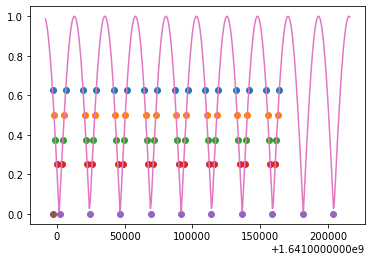

In [26]:
roots_up = root_calculation(0.5*1.25)
roots_normal = root_calculation(0.5)
roots_down = root_calculation(0.5*0.75)
roots_min = root_calculation(0.25)
roots_tide = [t[0] for t in FG.nodes['Node 4']['Info']['Tidal periods']]
root_sim = simulation_start.timestamp()+26000/4.5
plt.plot(roots_up,0.5*1.25*np.ones(len(roots_up)),'o')
plt.plot(roots_normal,0.5*np.ones(len(roots_normal)),'o')
plt.plot(roots_down,0.5*0.75*np.ones(len(roots_down)),'o')
plt.plot(roots_min,0.25*np.ones(len(roots_min)),'o')
plt.plot(roots_tide,np.zeros(len(roots_tide)),'o')
plt.plot(root_sim,0,'o')
plt.plot(FG.nodes['Node 4']['Info']['Horizontal tidal restriction']['Data']['Node 3'][0],
         FG.nodes['Node 4']['Info']['Horizontal tidal restriction']['Data']['Node 3'][1]);
#plt.plot([time[0]+26000/4.5 for time in times_tidal_window_calculated],np.zeros(len(times_tidal_window_calculated)),'o')
#plt.plot([time[0]+26000/4.5 for time in times_tidal_window_simulated],np.zeros(len(times_tidal_window_simulated)),'o')

In [27]:
simulation_start.timestamp()

1640991600.0

In [36]:
delay = -1/4*12.5*60*60
time = np.arange(0,duration,600)
current_directions = []
tidal_period = 'Flood'
tidal_period_count = 0
for t in range(len(time)):
    if t == 0:
        if tidal_period == 'Flood':
            current_direction = 90/360*2*np.pi
        elif tidal_period == 'Ebb':
            current_direction = 270/360*2*np.pi
        current_directions.append(current_direction)
        continue

    if tidal_period_count == 0 and (time[t])%(0.25*12.5*60*60+delay+0.001) < (time[t-1])%(0.25*12.5*60*60+delay+0.001):
        if tidal_period == 'Flood':
            tidal_period = 'Ebb'
        elif tidal_period == 'Ebb':
            tidal_period = 'Flood'
        tidal_period_count += 1

    elif tidal_period_count >= 1 and (time[t]-0.25*12.5*60*60-delay+0.001)%(0.5*12.5*60*60) < (time[t-1]-0.25*12.5*60*60-delay)%(0.5*12.5*60*60):
        if tidal_period == 'Flood':
            tidal_period = 'Ebb'
        elif tidal_period == 'Ebb':
            tidal_period = 'Flood'
        tidal_period_count += 1

    if tidal_period == 'Flood':
        current_direction = 90/360*2*np.pi
    elif tidal_period == 'Ebb':
        current_direction = 270/360*2*np.pi    
    current_directions.append(current_direction)